# Ensemble learning

In [37]:
from typing import Tuple, TypeVar, Dict, Any, List

from collections import defaultdict

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import cauchy
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

SklearnClass = TypeVar("SklearnClass") # The class itself (e.g. DecisionTreeRegressor)
SklearnModel = TypeVar("SklearnModel") # A class instance (e.g. DecisionTreeRegressor(max_depth=1))    

In [2]:
random_seed = 42
np.random.seed(random_seed)

In [3]:
deep_grey = '#3B4856' # основной тёмный / холодный цвет
sky_blue = '#348FEA'
marine_green = '#4CB9C0'
grass_green = '#97C804'
medium_yellow = '#FFC100' # основной светлый / тёплый цвет
sicilian_orange = '#E06A27'
fuchsia_pink = '#C81D6B'
saturated_violet = '#5002A7'
navy_blue = '#292183'
cool_white = '#F5FBFF'

$\newcommand{\Var}{\operatorname{\mathbb{V}\text{ar}}}$
$\newcommand{\Exp}{\operatorname{\mathbb{E}}}$
$\newcommand{\eps}{\varepsilon}$

Предположим, что мы решаем задачу регрессии с квадратичной функцией потерь. При использовании квадратичной функции потерь для оценки качества работы алгоритма $a$ можно использовать следующий функционал:

$$
    Q(a) = \Exp_x \Exp_{X, \eps} [y(x, \eps) - a(x, X)]^2,
$$

где 

- $X$ -- обучающая выборка 
- $x$ -- точка из тестового множества 
- $y = f(x) + \eps$ -- целевая зависимость, которую мы можем измерить с точностью до случайного шума $\eps$
- $a(x, X)$ -- значение алгоритма, обученного на выборке $X$, в точке $x$
- $\Exp_x$ -- среднее по всем тестовым точкам и $\Exp_{X, \eps}$ -- среднее по всем обучающим выборкам $X$ и случайному шуму $\eps$

<u> Bias-variance decomposition </u>. Существует представление $Q(a)$ в виде трёх компонент:

$$
    Q(a) = \Exp_x \text{bias}_X^2 a(x, X) + \Exp_x \Var_X[a(x, X)] + \sigma^2,
$$

где

$$
    \text{bias}_X a(x, X) = f(x) - \Exp_X[a(x, X)]
$$

-- **смещение** предсказания алгоритма в точке $x$, усреднённого по всем возможным обучающим выборкам, относительно истинной зависимости $f$,

$$
    \Var_X[a(x, X)] = \Exp_X \left[ a(x, X) - \Exp_X[a(x, X)] \right]^2
$$

-- **дисперсия (разброс)** предсказаний алгоритма в зависимости от обучающей выборки $X$,

$$
    \sigma^2 = \Exp_x \Exp_\eps[y(x, \eps) - f(x)]^2
$$ 

-- неустранимый **шум** в данных.

# Bias-variance для случайных деревьев разной глубины

Вычислим смещение и разброс на примере

In [39]:
def f(x: np.ndarray) -> np.ndarray:
      return x * np.sin(x)

def generate_data(n_samples: int = 50, 
                  noise: float = 3, 
                  n_noise_samples: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    
    x = np.random.rand(n_samples) * 20 - 10
    x = np.sort(x)
    y = np.zeros((n_samples, n_noise_samples))
    for i in range(n_noise_samples):
        y[:, i] = f(x) + np.random.normal(0.0, noise, n_samples)
    return x.reshape((n_samples, 1)), y.squeeze()

x, y = generate_data(n_samples = 50, noise=3, n_noise_samples=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

In [38]:
# plt.figure(dpi=150)
# plt.title('Data sample' , fontsize=15)
# plt.plot(np.linspace(-10, 10), 
#          f(np.linspace(-10, 10)), 
#          color=sky_blue, 
#          label="True function")
# plt.scatter(x_train, y_train, 
#             color = medium_yellow, 
#             label = "Train samples")
# plt.scatter(x_test, y_test, 
#             color = deep_grey, 
#             label = "Test samples")
# plt.legend()
# plt.show()

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = np.reshape(x_train, (x_train.shape[0])), y = y_train, mode='markers', name = 'train' ))
fig.add_trace(go.Scatter(x = np.reshape(x_test, (x_train.shape[0])), y = y_test, mode='markers', name = 'test'  ))
fig.add_trace(go.Scatter(x = np.linspace(-10, 10), y = f(np.linspace(-10, 10)), name = '$f(x) = x \dot sin(x)$'))

fig.show()

In [46]:
def train_classifier_on_random_subset(clf_class: SklearnClass, 
                                      parameters: Dict[str, Any], 
                                      n_train_samples: int = 20, 
                                      noise: float = 3) -> Tuple[SklearnModel, List[np.ndarray]]:

    x_train, y_train = generate_data(n_samples = n_train_samples, noise = noise,  n_noise_samples=1)
    clf = clf_class(**parameters)
    clf.fit(x_train, y_train)
    return clf, x_train, y_train

Посмотрим на то, как предсказания деревьев зависят от обучающих подмножеств и максимальной глубины дерева.

In [88]:
regressors = [
   [DecisionTreeRegressor, {"max_depth": 1}],
   [DecisionTreeRegressor, {"max_depth": 5}],
   [DecisionTreeRegressor, {"max_depth": 10}],
]

n_regressors = len(classifiers)
n_tries = 3



x_ticks = np.linspace(-10, 10)

for i, (clf_class, parameters) in enumerate(classifiers):
    fig = make_subplots(rows=1, cols=n_tries, subplot_titles=("random train_set 1", 
                                                              "random train_set 2", 
                                                              "random train_set 3"))
    
    fig.update_layout(title = "max_depth = {}".format(parameters["max_depth"]))
    np.random.seed(random_seed) # To make training subsets be identical for all classifiers
    for j in range(n_tries):
        clf, x_train, y_train = train_classifier_on_random_subset(clf_class=clf_class, parameters=parameters, noise=3)
        prediction = clf.predict(x_ticks[:, None])
        
        fig.add_trace(go.Scatter(x = x_ticks, y = f(x_ticks),  name='$f(x) = x\sin{x}$', mode='lines'), 1, j+1)
        fig.add_trace(go.Scatter(x = x_ticks, y = y_train,  name='Train y', mode='markers'), 1, j+1)
        fig.add_trace(go.Scatter(x = x_ticks, y = prediction,  name='Prediction', mode='lines'), 1, j+1)
    fig.show()

Для обучения деревьев насемплируем 1000 случайных подмножеств $X_{train} = (x_{train}, y_{train})$ размера 500, а для тестирования зафиксируем случайное тестовое подмножество точек $x_{test}$ также размера 500. 

Чтобы вычислить матожидание по $\eps$, нам нужно несколько экземпляров шума $\eps$ для тестовых лейблов: 
$$y_{test} = y(x_{test}, \hat \eps) = f(x_{test}) + \hat \eps$$

Положим количество семплов случайного шума равным 300. 

Для фиксированных $$X_{train} = (x_{train}, y_{train}) \text{ и }  X_{test} = (x_{test}, y_{test})$$ квадратичная ошибка вычисляется как

$$ MSE = (y_{test} - a(x_{test}, X_{train}))^2 $$

Взяв среднее от $MSE$ по $X_{train}$, $x_{test}$ и $\eps$, мы получим оценку для $Q(a)$, а оценки для компонент ошибки мы получим по ранее выведенным формулам. 

In [89]:
# defaultdict(list)

In [90]:
def get_predictions(classifiers: List[Tuple[SklearnClass, Dict[str, Any]]], 
                    n_tries: int, 
                    noise: float, 
                    n_train_samples: int, 
                    n_test_samples: int, 
                    n_noise_samples: int) -> List[Dict[int, Any]]:
  
    x_test, y_test = generate_data(n_samples=n_test_samples, 
                                   n_noise_samples=n_noise_samples, 
                                   noise=noise)
    predictions = defaultdict(list)

    for i, (clf_class, parameters) in enumerate(classifiers):
        np.random.seed(random_seed)
    
        for j in tqdm(range(n_tries), desc = f"{clf_class.__name__}, {parameters}"):
            
            clf, x_train, y_train = train_classifier_on_random_subset(clf_class = clf_class, 
                                                          parameters = parameters, 
                                                          n_train_samples = n_train_samples,
                                                          noise = noise)
            #print(x_train.shape, y_train.shape)
            predictions[i].append(clf.predict(x_test))

    results = []
    for i, (clf_class, parameters) in enumerate(classifiers):
        results.append({"name": clf_class.__name__,
                        "parameters": parameters,
                        "predictions": np.stack(predictions[i]),
                        "x_test": x_test,
                        "y_test": y_test })
  
    return results

In [91]:
classifiers = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers,
    n_tries=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 15}: 100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1166.34it/s]


In [92]:
print(f"predictions shape: n_tries × n_test_samples = {results[0]['predictions'].shape}")
print(f"x_test shape: n_test_samples × 1 = {results[0]['x_test'].shape}")
print(f"y_test shape: n_test_samples × n_noise_samples = {results[0]['y_test'].shape}")

predictions shape: n_tries × n_test_samples = (1000, 500)
x_test shape: n_test_samples × 1 = (500, 1)
y_test shape: n_test_samples × n_noise_samples = (500, 300)


### Вычислим компоненты разложения ошибки для каждого из классификаторов.

In [93]:
def get_bias_variance(results: Dict[str, Any]) -> pd.DataFrame:
    records = []
    
    for res in results:
        x_test, y_test = res["x_test"], res["y_test"]
        predictions = res["predictions"]
        bias = f(x_test).squeeze() - np.mean(predictions, axis=0)
        variance = np.var(predictions, axis=0)
        noise = np.var(y_test, axis=1)
        error = (predictions[..., None] - y_test[None]) ** 2

        records.append({
            "name": res["name"],
            "parameters": res["parameters"],
            "bias_sq": np.mean(bias ** 2),
            "variance": np.mean(variance),
            "noise": np.mean(noise),
            "error": np.mean(error),
            "decomposition": np.mean(bias ** 2 + variance + noise)
        })

    return pd.DataFrame.from_records(records)


In [94]:
get_bias_variance(results)

,name,parameters,bias_sq,variance,noise,error,decomposition
0,DecisionTreeRegressor,{'max_depth': 1},9.538297,1.659189,8.971014,20.168596,20.168500
1,DecisionTreeRegressor,{'max_depth': 2},5.085339,1.650574,8.971014,15.740351,15.706927
2,DecisionTreeRegressor,{'max_depth': 3},2.129631,2.077819,8.971014,13.215631,13.178464
3,DecisionTreeRegressor,{'max_depth': 4},0.423197,1.748217,8.971014,11.174658,11.142428
4,DecisionTreeRegressor,{'max_depth': 5},0.145411,1.829574,8.971014,10.976485,10.945999
5,DecisionTreeRegressor,{'max_depth': 6},0.038503,2.521282,8.971014,11.558981,11.530799
6,DecisionTreeRegressor,{'max_depth': 7},0.010943,3.398563,8.971014,12.406634,12.380520
7,DecisionTreeRegressor,{'max_depth': 8},0.005651,4.316676,8.971014,13.319238,13.293341
8,DecisionTreeRegressor,{'max_depth': 9},0.004788,5.222042,8.971014,14.224752,14.197845
9,DecisionTreeRegressor,{'max_depth': 10},0.005301,6.046255,8.971014,15.049358,15.022570


Нарисуем все три компоненты ошибки и саму ошибку на одном графике.

In [109]:
def plot_bias_variance(bias_variance_results: pd.DataFrame, 
                       target_parameter_name: str,  
                       target_parameter_values: List[float]) -> None:
    fig = go.Figure()
    bias = bias_variance_results.bias_sq
    var = bias_variance_results.variance
    noise = bias_variance_results.noise
    error = bias_variance_results.error
    fig.add_trace(go.Scatter(x = target_parameter_values, y = bias, mode='markers+lines', name = "bias"))
    fig.add_trace(go.Scatter(x = target_parameter_values, y = var, mode='markers+lines', name = "variance" ))
    fig.add_trace(go.Scatter(x = target_parameter_values, y = noise, mode='markers+lines', name = "noise = $\sigma^2$" ))
    fig.add_trace(go.Scatter(x = target_parameter_values, y = error, mode='markers+lines', name = "error" ))
    fig.update_xaxes(title='Максимальная глубина дерева (max_depth)')
    fig.show()

In [99]:
bias_variance_trees = get_bias_variance(results)
depth = bias_variance_trees.apply(lambda r: r.parameters["max_depth"], axis=1)

In [110]:
plot_bias_variance(bias_variance_trees, target_parameter_name="Tree depth", target_parameter_values=depth)

Видно, что при увеличении глубины деревьев смещение падает практически до нуля, а разброс нарастает. Правда, если взять достаточно много деревьев, разброс тоже станет постоянным:

In [111]:
classifiers = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 26)]

results = get_predictions(
    classifiers,
    n_tries=1000, 
    n_test_samples=500, 
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 25}: 100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 1144.03it/s]


In [113]:
bias_variance_many_trees = get_bias_variance(results)
depth_many = bias_variance_many_trees.apply(lambda r: r.parameters["max_depth"], axis=1)

In [114]:
plot_bias_variance(
    bias_variance_many_trees, 
    target_parameter_name = "Tree depth",  
    target_parameter_values = depth_many)

# Bias-variance для бэггинга

Попробуем посмотреть, как выглядят предсказания деревьев глубины 7 и бэггинга над такими деревьями в зависимости от обучающей выборки. Поскольку бэггинг by-design семплирует себе случайные подмножества, мы будем передавать ему на вход 10 000 случайных примеров, из которых он 10 раз (столько деревьев мы включим в ансамбль) насемплирует обучающие подмножества размера 20. Деревья также будут обучаться на 20 примерах.

In [134]:
class BaggingOnTrees(BaggingRegressor):
    def __init__(self, 
                 max_depth: int, 
                 max_samples: int, 
                 n_estimators: int):
        
        base_estimator = DecisionTreeRegressor(max_depth = max_depth)
        super().__init__(base_estimator = base_estimator, 
                         max_samples = max_samples, 
                         n_estimators = n_estimators)

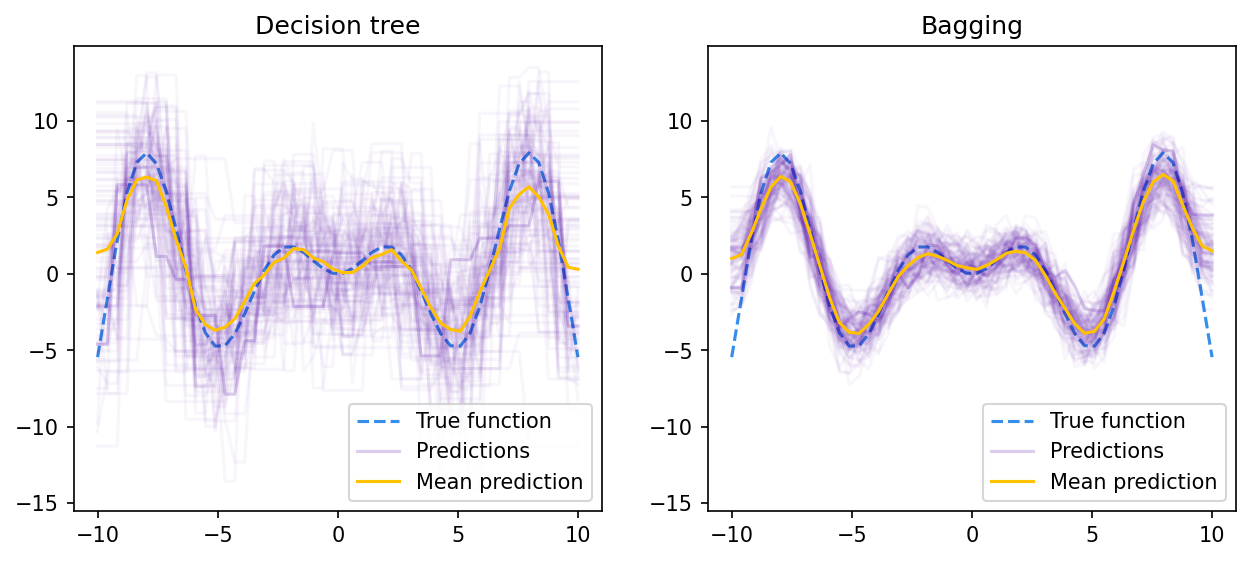

In [117]:
def plot_many_predictions(axs, x_ticks: np.ndarray, 
                          clf_class: SklearnClass, 
                          parameters: Dict[str, Any], 
                          n_tries: int, 
                          n_train_samples: int,
                          title: str) -> None:
  
    axs.plot(x_ticks, f(x_ticks), color = sky_blue, label="True function", linestyle="--")
    
    np.random.seed(random_seed)
    predictions = []
    for j in range(n_tries):
        clf, x_train, y_train = train_classifier_on_random_subset(clf_class=clf_class, 
                                                      parameters=parameters, 
                                                      noise=3,
                                                      n_train_samples=n_train_samples)
        prediction = clf.predict(x_ticks[:, None])
        predictions.append(prediction)
        if j == 0:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.2, label="Predictions")
        else:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.04)

    axs.plot(x_ticks, 
             np.mean(np.stack(predictions), axis=0), 
             label="Mean prediction", 
             color=medium_yellow)
    axs.set_title(title)
    axs.legend(loc="lower right")


n_tries = 100
x_ticks = np.linspace(-10, 10)
n_rows, n_cols = 1, 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 4), dpi=150, sharey=True)
fig.subplots_adjust(top=0.9)

plot_many_predictions(
    axs=ax[0], x_ticks=x_ticks, clf_class=DecisionTreeRegressor, 
    parameters={"max_depth": 7}, 
    n_tries=n_tries, 
    n_train_samples=20, 
    title="Decision tree")

plot_many_predictions(
    axs=ax[1], x_ticks=x_ticks, 
    clf_class = BaggingOnTrees,
    parameters = {"max_samples": 20, "n_estimators": 10, "max_depth": 7}, 
    n_tries=n_tries, n_train_samples=10000,
    title="Bagging")

ax[1].yaxis.set_tick_params(labelbottom=True)

plt.show()

По графикам кажется, что общая дисперсия предсказаний в зависимости от обучающего множества у бэггинга значительно ниже, а в среднем предсказания деревьев и бэггинга не отличаются. Убедимся, что эти наблюдения верны с помощью bias-variance decomposition.

Попробуем посмотреть, как будет выглядеть bias-variance для бэггинга над деревьями в зависмости от глубины входящих в бэггинг деревьев.

In [118]:
classifiers = [[BaggingOnTrees, {"max_samples": 500, "n_estimators": 10, "max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers, 
    n_tries=100, 
    n_test_samples=500, 
    n_train_samples=10000,
    n_noise_samples=300,
    noise=3
)

BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 1}: 100%|██████| 100/100 [00:02<00:00, 44.90it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 2}: 100%|██████| 100/100 [00:01<00:00, 59.56it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 3}: 100%|██████| 100/100 [00:01<00:00, 58.82it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 4}: 100%|██████| 100/100 [00:01<00:00, 56.67it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 5}: 100%|██████| 100/100 [00:01<00:00, 56.17it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 6}: 100%|██████| 100/100 [00:01<00:00, 54.47it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 7}: 100%|██████| 100/100 [00:01<00:00, 51.48it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 8}: 100%|██████| 100/100 [00:01<00:00, 50.33it/s]
BaggingOnTrees, {'max_samples': 500, 'n_

In [119]:
bias_variance_bagging = get_bias_variance(results)

In [120]:
plot_bias_variance(
    bias_variance_bagging, target_parameter_name="Tree depth",  
    target_parameter_values=bias_variance_bagging.apply(lambda r: r.parameters["max_depth"], axis=1)
)

Видно, что дисперсия у бэггинга гораздо ниже, чем была у единичных деревьев, а разброс выглядит почти так же. Для того, чтобы в этом точно убедиться, сравним смещения и разбросы деревьев и бэггинга на разных графиках.

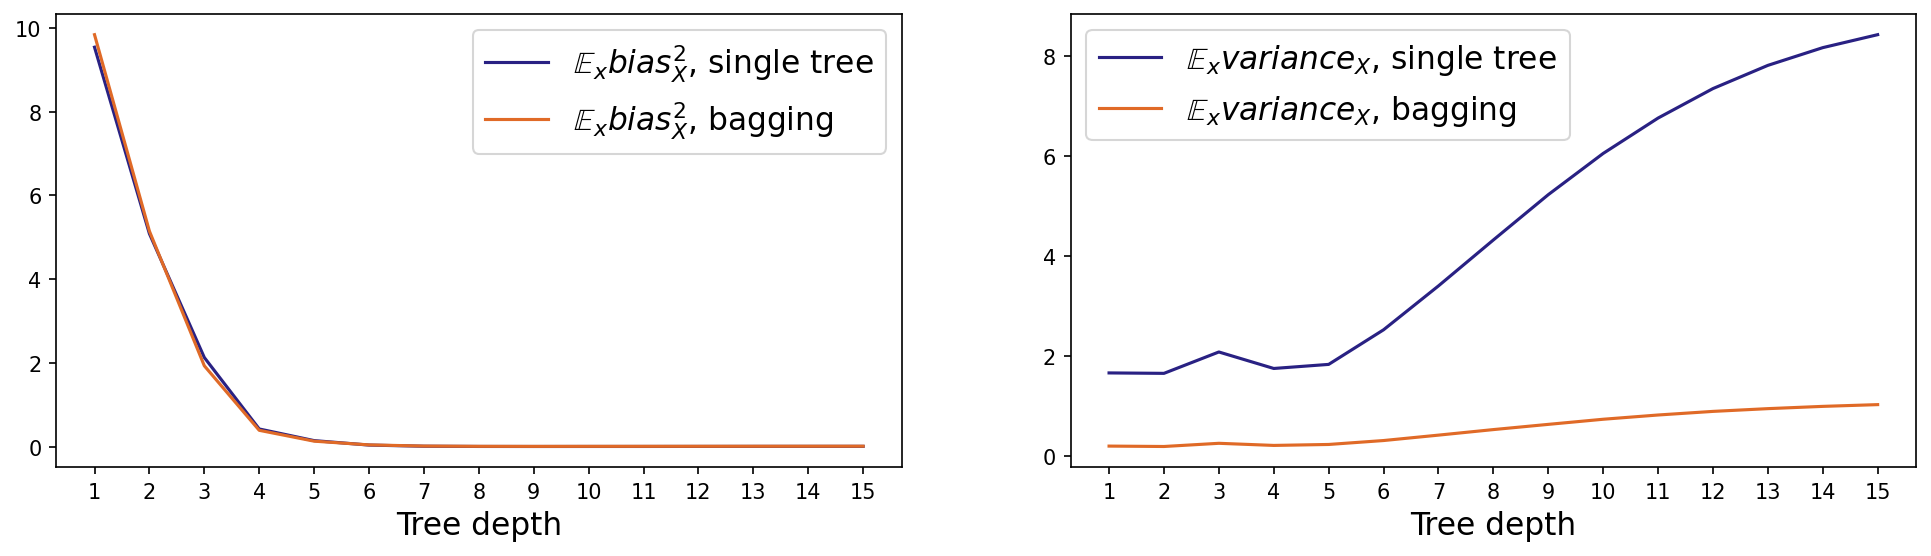

In [121]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(16, 4))

ax[0].set_xticks(depth)
ax[0].plot(depth, bias_variance_trees.bias_sq, label="$\mathbb{E}_x bias_X^2$, single tree", color=navy_blue)
ax[0].plot(depth, bias_variance_bagging.bias_sq, label="$\mathbb{E}_x bias_X^2$, bagging", color=sicilian_orange)
ax[0].set_xlabel("Tree depth", fontsize=15)
ax[0].legend(fontsize=15)

ax[1].set_xticks(depth)
ax[1].plot(depth, bias_variance_trees.variance, label="$\mathbb{E}_x variance_X$, single tree", color=navy_blue)
ax[1].plot(depth, bias_variance_bagging.variance, label="$\mathbb{E}_x variance_X$, bagging", color=sicilian_orange)
ax[1].set_xlabel("Tree depth", fontsize=15)
ax[1].legend(fontsize=15)
plt.show()

На графике видно, как значительно беггинг сократил дисперсию. На самом деле, дисперсия уменьшилась практически в 10 раз, что равняется числу моделей, которые бэггинг использовал для предсказания.

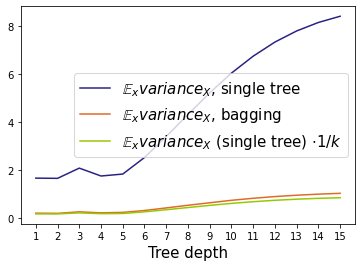

In [123]:
# plt.figure(dpi=150, figsize=(8, 5))
plt.xticks(depth)
plt.plot(depth, bias_variance_trees.variance, label="$\mathbb{E}_x variance_X$, single tree", color=navy_blue)
plt.plot(depth, bias_variance_bagging.variance, label="$\mathbb{E}_x variance_X$, bagging", color=sicilian_orange)
plt.plot(depth, bias_variance_trees.variance / 10, label="$\mathbb{E}_x variance_X$ (single tree) $\cdot 1 / k$", color=grass_green)
plt.xlabel("Tree depth", fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Bias-variance для Random Forest

In [140]:
from sklearn.ensemble import RandomForestRegressor

class RandomForest(RandomForestRegressor):
    def __init__(self, 
                 max_depth: int, 
                 max_samples: int ):
                 #n_estimators: int
        
        #base_estimator = DecisionTreeRegressor(max_depth = max_depth)
        super().__init__(#base_estimator = base_estimator, 
                         max_samples = max_samples)
                         #n_estimators = n_estimators)

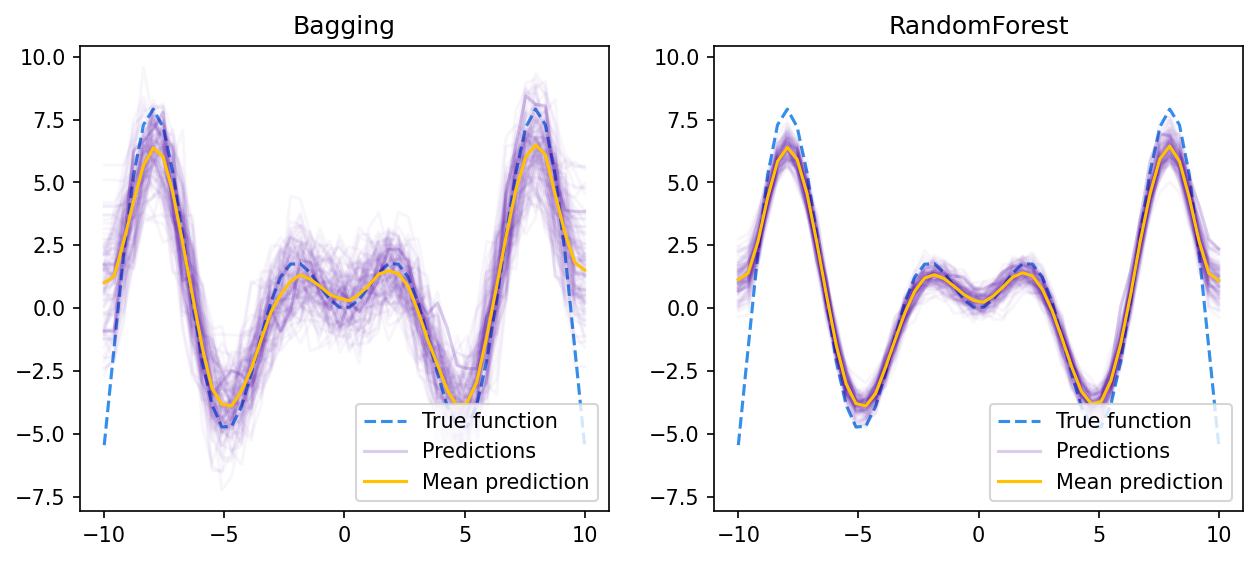

In [141]:
def plot_many_predictions(axs, x_ticks: np.ndarray, 
                          clf_class: SklearnClass, 
                          parameters: Dict[str, Any], 
                          n_tries: int, 
                          n_train_samples: int,
                          title: str) -> None:
  
    axs.plot(x_ticks, f(x_ticks), color = sky_blue, label="True function", linestyle="--")
    
    np.random.seed(random_seed)
    predictions = []
    for j in range(n_tries):
        clf, x_train, y_train = train_classifier_on_random_subset(clf_class=clf_class, 
                                                      parameters=parameters, 
                                                      noise=3,
                                                      n_train_samples=n_train_samples)
        prediction = clf.predict(x_ticks[:, None])
        predictions.append(prediction)
        if j == 0:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.2, label="Predictions")
        else:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.04)

    axs.plot(x_ticks, 
             np.mean(np.stack(predictions), axis=0), 
             label="Mean prediction", 
             color=medium_yellow)
    axs.set_title(title)
    axs.legend(loc="lower right")


n_tries = 100
x_ticks = np.linspace(-10, 10)
n_rows, n_cols = 1, 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 4), dpi=150, sharey=True)
fig.subplots_adjust(top=0.9)

# plot_many_predictions(
#     axs=ax[0], x_ticks=x_ticks, 
#     clf_class = DecisionTreeRegressor, 
#     parameters = {"max_depth": 7}, 
#     n_tries = n_tries, 
#     n_train_samples = 20, 
#     title="Decision tree")

plot_many_predictions(
    axs=ax[0], x_ticks=x_ticks, 
    clf_class = BaggingOnTrees,
    parameters = {"max_samples": 20, "n_estimators": 10, "max_depth": 7}, 
    n_tries = n_tries, 
    n_train_samples=10000,
    title="Bagging")

plot_many_predictions(
    axs=ax[1], x_ticks=x_ticks, 
    clf_class = RandomForest,
    parameters = {"max_samples": 20, "max_depth": 7}, 
    n_tries = n_tries, 
    n_train_samples=10000,
    title = "RandomForest")

ax[1].yaxis.set_tick_params(labelbottom=True)

plt.show()

In [142]:
classifiers = [[RandomForest, 
                {"max_samples": 500, 
                 # "n_estimators": 10, 
                 "max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers, 
    n_tries=100, 
    n_test_samples=500, 
    n_train_samples=10000,
    n_noise_samples=300,
    noise=3
)

RandomForest, {'max_samples': 500, 'max_depth': 1}: 100%|████████████████████████████| 100/100 [00:18<00:00,  5.55it/s]
RandomForest, {'max_samples': 500, 'max_depth': 2}: 100%|████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]
RandomForest, {'max_samples': 500, 'max_depth': 3}: 100%|████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]
RandomForest, {'max_samples': 500, 'max_depth': 4}: 100%|████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]
RandomForest, {'max_samples': 500, 'max_depth': 5}: 100%|████████████████████████████| 100/100 [00:17<00:00,  5.58it/s]
RandomForest, {'max_samples': 500, 'max_depth': 6}: 100%|████████████████████████████| 100/100 [00:18<00:00,  5.53it/s]
RandomForest, {'max_samples': 500, 'max_depth': 7}: 100%|████████████████████████████| 100/100 [00:16<00:00,  5.88it/s]
RandomForest, {'max_samples': 500, 'max_depth': 8}: 100%|████████████████████████████| 100/100 [00:17<00:00,  5.61it/s]
RandomForest, {'max_samples': 500, 'max_

In [145]:
# results

In [144]:
bias_variance_RandomForest = get_bias_variance(results)

In [146]:
bias_variance_RandomForest

,name,parameters,bias_sq,variance,noise,error,decomposition
0,RandomForest,"{'max_samples': 500, 'max_depth': 1}",0.003534,0.311048,8.976365,9.318952,9.290946
1,RandomForest,"{'max_samples': 500, 'max_depth': 2}",0.003534,0.311048,8.976365,9.318952,9.290946
2,RandomForest,"{'max_samples': 500, 'max_depth': 3}",0.003534,0.311048,8.976365,9.318952,9.290946
3,RandomForest,"{'max_samples': 500, 'max_depth': 4}",0.003534,0.311048,8.976365,9.318952,9.290946
4,RandomForest,"{'max_samples': 500, 'max_depth': 5}",0.003534,0.311048,8.976365,9.318952,9.290946
5,RandomForest,"{'max_samples': 500, 'max_depth': 6}",0.003534,0.311048,8.976365,9.318952,9.290946
6,RandomForest,"{'max_samples': 500, 'max_depth': 7}",0.003534,0.311048,8.976365,9.318952,9.290946
7,RandomForest,"{'max_samples': 500, 'max_depth': 8}",0.003534,0.311048,8.976365,9.318952,9.290946
8,RandomForest,"{'max_samples': 500, 'max_depth': 9}",0.003534,0.311048,8.976365,9.318952,9.290946
9,RandomForest,"{'max_samples': 500, 'max_depth': 10}",0.003534,0.311048,8.976365,9.318952,9.290946


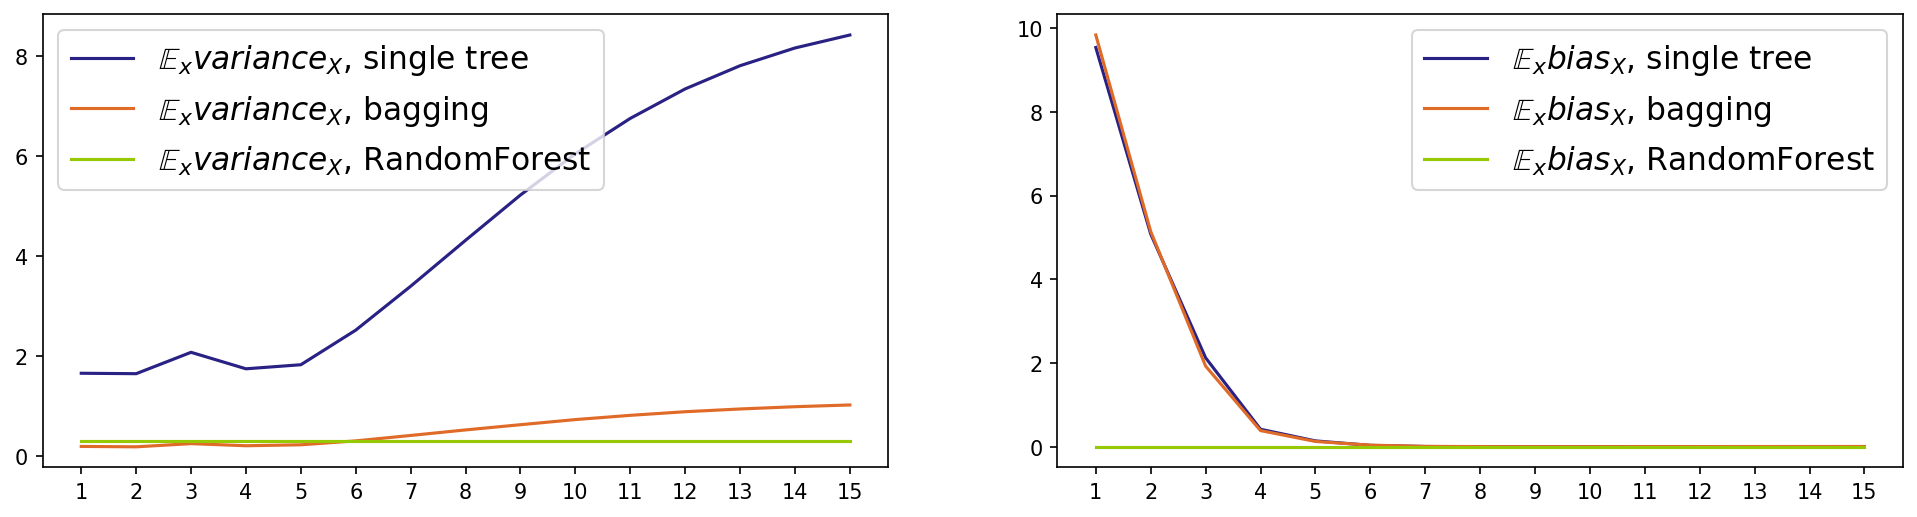

In [158]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(16, 4))

ax[0].set_xticks(depth)
ax[0].plot(depth, bias_variance_trees.variance, label="$\mathbb{E}_x variance_X$, single tree", color=navy_blue)
ax[0].plot(depth, bias_variance_bagging.variance, label="$\mathbb{E}_x variance_X$, bagging", color=sicilian_orange)
ax[0].plot(depth, bias_variance_RandomForest.variance, label="$\mathbb{E}_x variance_X$, RandomForest", color=grass_green)
ax[0].legend(fontsize=15)

ax[1].set_xticks(depth)
ax[1].plot(depth, bias_variance_trees.bias_sq, label="$\mathbb{E}_x bias_X$, single tree", color=navy_blue)
ax[1].plot(depth, bias_variance_bagging.bias_sq, label="$\mathbb{E}_x bias_X$, bagging", color=sicilian_orange)
ax[1].plot(depth, bias_variance_RandomForest.bias_sq, label="$\mathbb{E}_x bias_X$, RandomForest", color=grass_green)
ax[1].legend(fontsize=15)
plt.show()